## List of tables: 

### 1. [Table S2: Quality-quantity trade-off, clarification treatments only](#ols_quantity_quality)
### 2. [Table S3: Quality-quantity trade-off, clarification vs. no clarification](#ols_quantity_quality_extra_combined)
### 3. [Table S4: Estimating treatment effects on quantity, combined](#quantity)
### 4. [Table S5: Estimating treatment effects on quality, combined](#quality)

## List of figures:

### 1. [Figure 4: Scatterplot quality vs. quantity, clarification traetments only](#scatter_quantity_quality)


#### Imports libraries

In [1]:
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Matrix algebra
import os  # File system handling
import pandas as pd  # Dataframe handling
import statsmodels.api as sm  # Regression analysis
import statsmodels.formula.api as smf  # Regressions analysis

from linearmodels.panel import RandomEffects  # Panel analysis
from linearmodels.panel.results import PanelModelComparison # Panelsummary table
from linearmodels.iv import IV2SLS # Instrumental variable
from linearmodels.iv.results import IVModelComparison # IV summary table
from matplotlib.ticker import FuncFormatter  # Formating graphs
from scipy import stats  #Statistics module
from statsmodels.iolib.summary2 import summary_col  # Regression output table
from statsmodels.stats.anova import anova_lm  # Regression anova table

#### Set project directory

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.dirname(os.getcwd()))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Set display format

In [3]:
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 40)

#### Set plotting style

In [4]:
plt.style.use('classic')

#### Set plotting properties 

In [5]:
bar_kw = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kw = dict(kind='line', lw=1, alpha=1, legend=True)
font_kw = dict(fontsize=11, color='k')
grid_kw = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
error_kw = dict(elinewidth=2, ecolor='0.15')
xlabel_kw = dict(fontsize=11, labelpad=3)
ylabel_kw = dict(fontsize=11, labelpad=3)
legend_kw = dict(frameon=False)
tick_kw = dict(
    size=5,
    which='both',
    direction='out',
    right=False,
    top=False,
    labelbottom=True
)

#### Retrieving dataframe

In [6]:
DATA = os.path.join(
    FINAL_DATA_FOLDER, 
    'experiment_1',                
    'data_final.feather'
)

df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Columns: 443 entries, Age to Q80_timer
dtypes: float64(225), int64(26), object(192)
memory usage: 10.4+ MB


#### Select treatments for robsutness check 

In [7]:
treatment_list = [3, 4, 6, 7, 9, 10, 11, 12]
sel = df['Treatment'].isin(treatment_list)
df = df[sel]

#### Table S4: Estimating treatment effects on quantity <a id='quantity'></a>

In [8]:
regs = dict()
regs['reg1'] = 'Counter_real ~ High_piece_rate'
regs['reg2'] = 'Counter_real ~ Praise'
regs['reg3'] = 'Counter_real ~ Clarification'
regs['reg4'] = 'Counter_real ~ High_piece_rate * Praise * Clarification'
regs['reg5'] = regs['reg4'] + ' + Age + Female + Education + Mobile_device + Latin_med'

ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]
    
order = [
    'High_piece_rate', 
    'Praise', 
    'Clarification',
    'High_piece_rate:Praise', 
    'High_piece_rate:Clarification', 
    'Praise:Clarification',
    'High_piece_rate:Praise:Clarification',
] 

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}', 
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}',
}

ols_quan = summary_col(
    ols_results, 
    stars=True, 
    info_dict=auxiliary, 
    float_format='%.3f', 
    regressor_order=order,
    drop_omitted=True
)

ols_quan = ols_quan\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('_', ' ').replace(':', ' * ').capitalize(), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_', ' '), axis=1)\

ols_quan.loc['Controls'] = pd.Series(4*['No'] + ['Yes'], index=ols_quan.columns)

path = os.path.join(
    TABLES_FOLDER, 
    'experiment_1', 
    'ols_quantity_extra.tex'
)
    
ols_quan.to_latex(path, float_format="%.3f")

ols_quan

,Counter real,Counter real,Counter real,Counter real,Counter real
High piece rate,0.094,,,0.240,-0.003
,(0.479),,,(0.801),(0.770)
Praise,,-0.863*,,-1.347*,-1.737**
,,(0.479),,(0.799),(0.766)
Clarification,,,0.269,-0.543,-0.706
,,,(0.564),(1.068),(1.031)
High piece rate * praise,,,,0.119,0.548
,,,,(1.095),(1.061)
High piece rate * clarification,,,,-0.087,0.475
,,,,(1.600),(1.526)


In [9]:
anova_lm(*ols_results, robust='hc1')

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1589.0,144968.298,0.0,NaN,NaN,NaN
1,1589.0,144675.281,-0.0,293.016,-inf,NaN
2,1589.0,144950.234,-0.0,-274.953,inf,NaN
3,1583.0,144327.395,6.0,622.839,1.222,2.919e-01
4,1578.0,134053.654,5.0,10273.741,24.187,1.618e-23


#### Transform dataframe to panel

In [10]:
columns_to_keep = df.columns[[0, 1, 12, 14, 16, 18, 23, 24, 25, 26, 29, 30, 32, 33, 34, 40]]
columns_to_melt = [f'Q{x}_editratio' for x in range(1, df['Counter'].max() + 1)]

df_melted = pd.melt(
    df, 
    id_vars=columns_to_keep,
    value_vars = columns_to_melt,
    var_name='Question_number',
    value_name='Edit_ratio'
)

df_melted = df_melted.dropna(axis=0, how='any', subset=['Edit_ratio'])
df_melted['Question_number'] = df_melted['Question_number'].str.extract(r'(\d+)').astype(int)
df_melted['Edit_ratio'] = df_melted['Edit_ratio'].astype(float)

df_panel = df_melted.set_index(['Id', 'Question_number'])
df_panel = df_panel.sort_index()
df_panel.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37818 entries, (200, 1) to (2195, 24)
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   37818 non-null  float64
 1   Clarification         37818 non-null  int64  
 2   Education             37818 non-null  int64  
 3   Female                37818 non-null  int64  
 4   High_piece_rate       37818 non-null  int64  
 5   Latin_med             37818 non-null  int64  
 6   Leadership_technique  37818 non-null  object 
 7   Low_piece_rate        37818 non-null  int64  
 8   Mobile_device         37818 non-null  int64  
 9   No_message            37818 non-null  int64  
 10  No_piece_rate         37818 non-null  int64  
 11  Performance_pay       37818 non-null  object 
 12  Praise                37818 non-null  int64  
 13  Reference_point       37818 non-null  int64  
 14  Treatment_str         37818 non-null  object 
 15  Edit_ra

#### Table S5: Estimating treatment effects on quality  <a id='quality'></a>

In [11]:
regs = dict()
regs['re1'] = 'Edit_ratio ~ 1 + High_piece_rate'
regs['re2'] = 'Edit_ratio ~ 1 + Praise'
regs['re3'] = 'Edit_ratio ~ 1 + Clarification'
regs['re4'] = 'Edit_ratio ~ 1 + High_piece_rate * Praise * Clarification'
regs['re5'] = regs['re4'] + ' + Age + Female + Education + Mobile_device + Latin_med'

re_results = [RandomEffects.from_formula(formula=v, data=df_panel).fit(cov_type='robust') for v in regs.values()]

re_qual = PanelModelComparison(re_results, precision='std-errors', stars=True)

path = os.path.join(
    TABLES_FOLDER, 
    'experiment_1', 
    're_extra_quality.tex'
)

with open(path, "w") as latex:
    latex.write(re_qual.summary.as_latex())

re_qual

,Model 0,Model 1,Model 2,Model 3,Model 4
Dep. Variable,Edit_ratio,Edit_ratio,Edit_ratio,Edit_ratio,Edit_ratio
Estimator,RandomEffects,RandomEffects,RandomEffects,RandomEffects,RandomEffects
No. Observations,37818,37818,37818,37818,37818
Cov. Est.,Robust,Robust,Robust,Robust,Robust
R-squared,0.0016,0.0016,0.0016,0.0018,0.0021
R-Squared (Within),0.0000,0.0000,0.0000,0.0000,0.0000
R-Squared (Between),0.0002,9.81e-05,0.0003,0.0054,0.0131
R-Squared (Overall),-0.0025,-0.0028,-0.0027,-0.0042,-0.0022
F-statistic,59.086,58.958,59.190,9.4896,6.5406
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000


#### Calculate average error rate and append to cross sectional dataframe

In [12]:
avg_edit_ratio = df_panel['Edit_ratio'].mean(level=0).to_frame(name='Avg_edit_ratio')
df = df.merge(avg_edit_ratio, left_on='Id', right_on='Id', validate='one_to_one')

#### Generate relative counter variable (completion rate) 

In [13]:
df['Rel_counter'] =  df['Counter_real'] / 80.0

#### Figure 2: Scatterplot quality vs. quantity, clarification traetments only <a id='scatter_quantity_quality'></a>

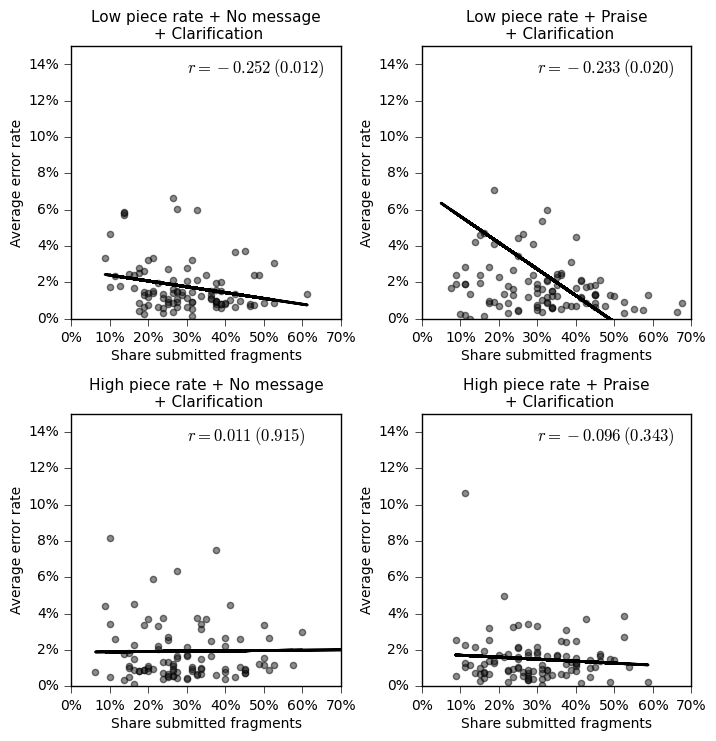

In [14]:
def get_fitted_values(df, x, y):
    y = df.loc[:,y]
    x = df.loc[:,x]
    x = sm.add_constant(x)
    ols = sm.OLS(y, x).fit()
    return ols.fittedvalues

treat_index = [
    'Low piece rate + No message + Clarification',
    'Low piece rate + Praise + Clarification',
    'High piece rate + No message + Clarification',
    'High piece rate + Praise + Clarification',
]

x_var, y_var = 'Rel_counter', 'Avg_edit_ratio'
scatter_params = dict(xlim=[0, 0.7], ylim=[0, 0.15], color='0.1', alpha=0.5)
with plt.style.context('classic'):
    fig, _ = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), dpi=100)
    fig.set_facecolor('w')
    fig.subplots_adjust(hspace=0.35, wspace=0.3)
    for i, ax in enumerate(fig.axes):
        df_scatter = df[(df['Treatment_str'] == treat_index[i])]
        df_scatter.plot.scatter(x=x_var, y=y_var, ax=ax, **scatter_params)
        ax.plot(df_scatter[x_var], get_fitted_values(df_scatter, x_var, y_var), c='0', lw=2)
        ax.set_title(treat_index[i].replace(' + Clarification', '\n + Clarification'), **font_kw)
        ax.set_xlabel("Share submitted fragments", fontsize='small', labelpad=3)
        ax.set_ylabel("Average error rate", fontsize='small', labelpad=3)
        ax.tick_params(labelsize='small', **tick_kw)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
        r, p = stats.pearsonr(df_scatter[x_var], df_scatter[y_var])
        ax.text(0.3, 0.135 , f'$r={r:.3f}\:({p:.3f})$') 

path = os.path.join(
    FIGURES_FOLDER,
    'experiment_1',
    'corr_counter_real_extra_editratio.pdf'
)        
fig.savefig(path)

#### Table S2: Quality-quantity trade-off, clarification treatments only  <a id='ols_quantity_quality'></a>

In [15]:
regs = {}
regs['re0'] = 'Avg_edit_ratio ~ Rel_counter'
regs['re1'] = 'Avg_edit_ratio ~ Rel_counter + C(Treatment_str)'
regs['re2'] = 'Avg_edit_ratio ~ Rel_counter + Rel_counter:C(Treatment_str)'
regs['re3'] = 'Avg_edit_ratio ~ Rel_counter * C(Treatment_str)'

sel = df['Treatment'].isin([9, 10, 11, 12])
ols_results = [smf.ols(formula=v, data=df[sel]).fit(cov_type='HC1') for v in regs.values()]

order = [
    'Rel_counter',
    'Intercept', 
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}', 
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}',
}

ols_qual_quan = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
    drop_omitted=True
)

ols_qual_quan = ols_qual_quan\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(']', ''), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('_',' '), axis=1)\
    .rename({'Intercept':'Constant'})\
    .rename_axis('Dependent variable:', axis=1)

ols_qual_quan.loc['Intercepts'] = pd.Series(['No', 'Yes', 'No', 'Yes'], index=ols_qual_quan.columns)
ols_qual_quan.loc['Slopes'] = pd.Series(['No', 'No', 'Yes', 'Yes'], index=ols_qual_quan.columns)

path = os.path.join(
    TABLES_FOLDER, 
    'experiment_1',
    'ols_quality_quantity_extra.tex',
)

ols_qual_quan.to_latex(
    path,
    bold_rows=True,
    float_format="%.3f"
)

ols_qual_quan

Dependent variable:,Avg edit ratio,Avg edit ratio,Avg edit ratio,Avg edit ratio
Rel_counter,-0.050,-0.052,-0.043,0.002
,(0.035),(0.036),(0.037),(0.015)
Constant,0.034***,0.035***,0.035***,0.019***
,(0.012),(0.011),(0.013),(0.004)
R-squared,0.019,0.028,0.021,0.058
R-squared Adj.,0.016,0.018,0.011,0.041
N,396,396,396,396
F,2.047,1.880,1.338,1.825
P(>F),0.153,0.113,0.255,0.081
Intercepts,No,Yes,No,Yes


#### Table S3: Quality-quantity trade-off, clarification vs. no clarification <a id='ols_quantity_quality_extra_combined'></a>

In [16]:
form_ols = 'Avg_edit_ratio ~ 1 + Rel_counter + Age + Female + Education + Mobile_device + Latin_med'
res_ols = IV2SLS.from_formula(form_ols, df[sel]).fit()

form_iv_first = 'Rel_counter ~ High_piece_rate * Praise + Age + Female + Education + Mobile_device + Latin_med'
res_iv_first = IV2SLS.from_formula(form_iv_first, df[sel]).fit()

form_iv = 'Avg_edit_ratio ~ 1 + Age + Female + Education + Mobile_device + Latin_med + ' \
 + '[Rel_counter ~ High_piece_rate * Praise]'
res_2sls = IV2SLS.from_formula(form_iv, df[sel]).fit()


res_all = {
    'OLS':res_ols, 
    'First':res_iv_first, 
    '2SLS':res_2sls
}

results = IVModelComparison(res_all, precision='std_errors', stars=True)

path = os.path.join(
    TABLES_FOLDER, 
    'experiment_1',    
    'iv2sls_extra.tex'
)

with open(path, "w") as latex:
    latex.write(results.summary.as_latex())
    
results

,OLS,First,2SLS
Dep. Variable,Avg_edit_ratio,Rel_counter,Avg_edit_ratio
Estimator,OLS,OLS,IV-2SLS
No. Observations,396,396,396
Cov. Est.,robust,robust,robust
R-squared,0.0314,0.0990,-2.8467
Adj. R-squared,0.0165,0.0803,-2.9060
F-statistic,9.5845,48.442,1.1820
P-value (F-stat),0.1433,8.131e-08,0.9778
========================,================,=============,================
Intercept,0.0457**,0.3530***,-0.1853


In [17]:
res_2sls.first_stage

,Rel_counter
R-squared,0.0990
Partial R-squared,0.0030
Shea's R-squared,0.0030
Partial F-statistic,1.1532
P-value (Partial F-stat),0.7643
Partial F-stat Distn,chi2(3)
==========================,===========
Intercept,0.3530
,(13.857)
Age,-0.0027


In [18]:
res_2sls.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 3.5949
P-value: 0.0580
Distributed: chi2(1)
WaldTestStatistic, id: 0x7ffaaee3f640

In [19]:
res_2sls.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 3.5545
P-value: 0.0601
Distributed: F(1,388)
WaldTestStatistic, id: 0x7ffaae3f4520

In [20]:
res_2sls.sargan

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 0.0591
P-value: 0.9709
Distributed: chi2(2)
WaldTestStatistic, id: 0x7ffaae301e50

###  Table S4: Quality vs. quantity, clarification vs. no clarification, study 1

In [21]:
regs = {}
regs['re0'] = 'Avg_edit_ratio ~ Rel_counter'
regs['re1'] = 'Avg_edit_ratio ~ Rel_counter * Clarification'
regs['re2'] = regs['re1'] + ' + Age + Female + Education + Mobile_device + Latin_med'

ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]

order = [
    'Rel_counter', 
    'Clarification', 
    'Rel_counter:Clarification',
    'Intercept'
] 

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}', 
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}',
}

ols_qual_quan = summary_col(
    ols_results, 
    stars=True, 
    info_dict=auxiliary, 
    float_format='%.3f', 
    regressor_order=order,
    drop_omitted=True,
)


ols_qual_quan.add_title('Regression table: Quality vs. Quantiy OLS')
ols_qual_quan = ols_qual_quan\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('C(treatment_str)[T.', '').replace(']', '').capitalize(), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_',' '), axis=1)\
    .rename({'Intercept':'Constant'})

ols_qual_quan.loc['Controls'] = pd.Series(['No', 'No', 'Yes'], index=ols_qual_quan.columns)

path = os.path.join(
    TABLES_FOLDER, 
    'experiment_1',
    'ols_quality_quanity_extra2.tex',
)

ols_qual_quan.to_latex(
    path,
    bold_rows=False,
    float_format="%.3f"
)

ols_qual_quan

,Avg edit ratio,Avg edit ratio,Avg edit ratio
Rel_counter,-0.042***,-0.040***,-0.041***
,(0.013),(0.012),(0.011)
Clarification,,0.005,0.004
,,(0.013),(0.013)
Rel_counter:clarification,,-0.010,-0.007
,,(0.037),(0.037)
Constant,0.031***,0.030***,0.038***
,(0.005),(0.004),(0.005)
R-squared,0.018,0.019,0.026
R-squared adj.,0.018,0.017,0.021


#### Calculate sample correlation coefficient over all additional treatments 

In [22]:
rho, p_rho = stats.pearsonr(df['Rel_counter'], df['Avg_edit_ratio'])
print(f'Sample correlation between share of fragments submitted and averaage quality is {rho:.3f} ({p_rho:.3f})')

Sample correlation between share of fragments submitted and averaage quality is -0.135 (0.000)


#### Calculate sample correlation coefficient with and without clarification statement 

In [23]:
for value in df['Clarification'].unique():
    x = df[df['Clarification'] == value]['Counter_real']
    y = df[df['Clarification'] == value]['Avg_edit_ratio']
    print(f'{value}: r={stats.pearsonr(x, y)[0]:.3f}, p={stats.pearsonr(x, y)[1]:.3f}, n={x.count()}') 

0: r=-0.135, p=0.000, n=1195
1: r=-0.137, p=0.006, n=396


#### Test difference in sample pcc with and without clarification statement 

In [24]:
def test_diff_r(r1, r2, n1, n2):
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    sd = np.sqrt((1 / (n1 - 3)) + (1 / (n2 - 3)))
    z = np.abs(z1 - z2) / sd
    p_one = stats.norm.sf(z)
    p_two = 2 * p_one
    return z, p_one, p_two 

result = test_diff_r(0.135, 0.137, 1195, 396)
print("z-score={0[0]:.3f}, p={0[1]:.3f} (one-tailed), p={0[2]:.3f} (two-tailed)".format(result)) 

z-score=0.035, p=0.486 (one-tailed), p=0.972 (two-tailed)


In [25]:
!jupyter nbconvert --output-dir='./docs' --to html 7_additional_figures.ipynb

[NbConvertApp] Converting notebook 7_additional_figures.ipynb to html
[NbConvertApp] Writing 792729 bytes to docs/7_additional_figures.html
